In [1]:
from data_load import LoadData, Normalization, ToTensor
from torchvision import transforms

import numpy as np

In [2]:
data_folder = "/home/user170/shared-data/Personal_Dev/Machine-Learning/Data/Depth/NYU-Depth-Dataset-V2/"

In [3]:
import os
def seperate_dataset(testset_ratio=0.3):
    """
    Seperate Train and Test dataset

    Returns: random indice of train test datasets, and length of those.
    """
    dataset_len = len(os.listdir(data_folder+"Images/RGB/"))
    rnd_indice = [i for i in range(dataset_len)]
    np.random.shuffle(rnd_indice)
    split_thresh = int(dataset_len*(1-testset_ratio))

    train_indice = rnd_indice[:split_thresh]
    test_indice = rnd_indice[split_thresh:]

    trainset_len = len(train_indice)
    testset_len = len(test_indice)

    return train_indice, test_indice, trainset_len, testset_len

trainset_indice, testset_indice, trainset_len, testset_len = seperate_dataset()

In [4]:
composed = transforms.Compose([ToTensor(norm=True)])
trainset = LoadData(root_dir=data_folder, dataset_list=trainset_indice, transform=composed)

print("RGB SHAPE: {}, MAX: {}, MIN:{}".format(np.shape(trainset[0]["RGB"].numpy()), np.max(trainset[0]["RGB"].numpy()), np.min(trainset[0]["RGB"].numpy())))
print("DEPTH SHAPE: {}, MAX: {}, MIN:{}".format(np.shape(trainset[0]["DEPTH"].numpy()), np.max(trainset[0]["DEPTH"].numpy()), np.min(trainset[0]["DEPTH"].numpy())))

RGB SHAPE: (3, 480, 640), MAX: 1.0, MIN:0.0
DEPTH SHAPE: (1, 480, 640), MAX: 1.0, MIN:0.0


In [5]:
from torch.utils.data import DataLoader

In [6]:
for i in range(len(trainset)):
    sample = trainset[i]
    
    print("<< {} >>".format(i))
    print("RGB SHAPE: {}, MAX: {}, MIN:{}".format(np.shape(trainset[0]["RGB"].numpy()), np.max(trainset[0]["RGB"].numpy()), np.min(trainset[0]["RGB"].numpy())))
    print("DEPTH SHAPE: {}, MAX: {}, MIN:{}".format(np.shape(trainset[0]["DEPTH"].numpy()), np.max(trainset[0]["DEPTH"].numpy()), np.min(trainset[0]["DEPTH"].numpy())))
    
    if i==3:
        break

<< 0 >>
RGB SHAPE: (3, 480, 640), MAX: 1.0, MIN:0.0
DEPTH SHAPE: (1, 480, 640), MAX: 1.0, MIN:0.0
<< 1 >>
RGB SHAPE: (3, 480, 640), MAX: 1.0, MIN:0.0
DEPTH SHAPE: (1, 480, 640), MAX: 1.0, MIN:0.0
<< 2 >>
RGB SHAPE: (3, 480, 640), MAX: 1.0, MIN:0.0
DEPTH SHAPE: (1, 480, 640), MAX: 1.0, MIN:0.0
<< 3 >>
RGB SHAPE: (3, 480, 640), MAX: 1.0, MIN:0.0
DEPTH SHAPE: (1, 480, 640), MAX: 1.0, MIN:0.0


In [7]:
dataloader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=4)

In [8]:
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, np.shape(sample_batched["RGB"]))
    
    if i_batch == 3:
        break

0 torch.Size([4, 3, 480, 640])
1 torch.Size([4, 3, 480, 640])
2 torch.Size([4, 3, 480, 640])
3 torch.Size([4, 3, 480, 640])


In [9]:
import matplotlib.pyplot as plt

def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

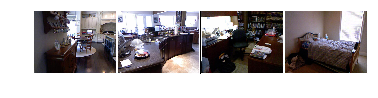

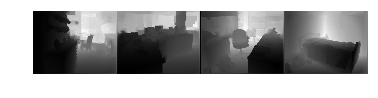

In [10]:
from torchvision.utils import make_grid

dataiter = iter(dataloader)

images = dataiter.next()

imshow(make_grid(images['RGB']))
imshow(make_grid(images['DEPTH']))

# Define a Coarse Networks

In [11]:
import torch.nn as nn

coarse = nn.Sequential(
    nn.Conv2d(3, 96, kernel_size=11, stride=4), nn.MaxPool2d(2),
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.MaxPool2d(2),
    nn.Conv2d(256, 384, kernel_size=3, padding=1),
    nn.Conv2d(384, 384, kernel_size=3, padding=1),
    nn.Conv2d(384, 256, kernel_size=3, stride=2))

In [12]:
isinstance([1, 2, 3], int)

False

In [13]:
class View(nn.Module):
    """ Convert a tensor to be a module so that it not only can be added to Sequential, but also the shape of it can be identified
    Args for class instance:
        *shape: sequence of numbers with int type.
    """
    def __init__(self, *shape):
        assert len(shape) != 0
        
        for i in shape:
            assert isinstance(i, int)

        super(View, self).__init__()
        self.shape = shape
        
    def forward(self, x):
        return x.view(self.shape)

In [14]:
import torch.nn as nn

class Coarse(nn.Module):
    def __init__(self):
        super(Coarse, self).__init__()

        self.coarse1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4),
            nn.ReLU(),
            nn.MaxPool2d(2))

        self.coarse2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2))

        self.coarse3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU())
        
        self.coarse4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU())
        
        self.coarse5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=2),
            nn.ReLU(),
            View(-1, 1, 256*8*6))
        
        self.linear6 = nn.Sequential(
            nn.Linear(256*8*6, 4096),
            nn.ReLU(),
            nn.Dropout2d())
        
        self.linear7 = nn.Sequential(
            nn.Linear(4096, 4070),
            View(-1, 1, 74, 55))
        
    def forward(self, x):
        coarse1 = self.coarse1(x)
        coarse2 = self.coarse2(coarse1)
        coarse3 = self.coarse3(coarse2)
        coarse4 = self.coarse4(coarse3)
        coarse5 = self.coarse5(coarse4)        
        coarse6 = self.linear6(coarse5)
        coarse7 = self.linear7(coarse6)
        
        return coarse7

In [15]:
coarse = Coarse()
coarse

Coarse(
  (coarse1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (coarse2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (coarse3): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (coarse4): Sequential(
    (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (coarse5): Sequential(
    (0): Conv2d(384, 256, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): View()
  )
  (linear6): Sequential(
    (0): Linear(in_features=12288, out_features=4096, bias=True)
    (1): ReLU()
    (2): Dropout2d(p=0.5)
  )
  (linear7): Sequential(
    (0): Linear(in_features=4096, out_features=4070, bias=True)
    (1)

In [16]:
from torchsummary import summary

summary(coarse.cuda(), (3, 304, 228))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 74, 55]          34,944
              ReLU-2           [-1, 96, 74, 55]               0
         MaxPool2d-3           [-1, 96, 37, 27]               0
            Conv2d-4          [-1, 256, 37, 27]         614,656
              ReLU-5          [-1, 256, 37, 27]               0
         MaxPool2d-6          [-1, 256, 18, 13]               0
            Conv2d-7          [-1, 384, 18, 13]         885,120
              ReLU-8          [-1, 384, 18, 13]               0
            Conv2d-9          [-1, 384, 18, 13]       1,327,488
             ReLU-10          [-1, 384, 18, 13]               0
           Conv2d-11            [-1, 256, 8, 6]         884,992
             ReLU-12            [-1, 256, 8, 6]               0
             View-13             [-1, 1, 12288]               0
           Linear-14              [-1, 

In [40]:
from torch import cat, randn, Tensor

class Concatenate(nn.Module):
    def __init__(self):        
        super(Concatenate, self).__init__()
        
    def forward(self, base_tensor1, base_tensor2, dim=0):
        assert type(base_tensor1) == Tensor and type(base_tensor2) == Tensor
        
        return cat((base_tensor1, base_tensor2), dim=dim)

In [65]:
class Fine(nn.Module):
    def __init__(self):
        super(Fine, self).__init__()
        
        self.fine1 = nn.Sequential(
            nn.Conv2d(3, 1, kernel_size=9, stride=2),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        self.fine2 = nn.Sequential(
            Concatenate())
        
    def forward(self, x, coarse7):
        fine1 = self.fine1(x)
        print(fine1)
        fine2 = self.fine2(fine1, coarse7)
        
        return fine2

In [66]:
fine = Fine()
fine

Fine(
  (fine1): Sequential(
    (0): Conv2d(3, 1, kernel_size=(9, 9), stride=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fine2): Sequential(
    (0): Concatenate()
  )
)

In [67]:
x = randn(3, 74, 55)
summary(fine.cuda(), [(3, 28, 28), (3, 28, 28)])

tensor([[[[0.0823, 0.1813, 0.2799, 0.0985, 0.2421],
          [0.2762, 0.1536, 0.1522, 0.3658, 0.2455],
          [0.4138, 0.1468, 0.3183, 0.1721, 0.1747],
          [0.3810, 0.2117, 0.2686, 0.2279, 0.0753],
          [0.1658, 0.2134, 0.1103, 0.1951, 0.1513]]],


        [[[0.2532, 0.3398, 0.1543, 0.1867, 0.2608],
          [0.2472, 0.1758, 0.1911, 0.4619, 0.2122],
          [0.0776, 0.1223, 0.0344, 0.3465, 0.1605],
          [0.1313, 0.2391, 0.0891, 0.2785, 0.3980],
          [0.4401, 0.2805, 0.0983, 0.1377, 0.1787]]]], device='cuda:0',
       grad_fn=<MaxPool2DWithIndicesBackward>)


TypeError: forward() takes 2 positional arguments but 3 were given